# Pre Processing Part 1
This notebook focuses on pre processing the FHVHV dataset, with relevant sections outlined

# 1. Filtering Data
For this section, we will look to deal with missing attributes,incorectly recorded data, missing data and other important trends. 

In [1]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/08/23 00:12:19 WARN Utils: Your hostname, James-N580VD-DM229T resolves to a loopback address: 127.0.1.1; using 172.27.35.106 instead (on interface eth0)
22/08/23 00:12:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/23 00:12:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# First lets read the dataset(s) ('march data will be used to testing predictive power')
#fhvfv
fhvhv_2021_09 = spark.read.parquet('../data/raw/fhvhv_tripdata_2021-09.parquet')
fhvhv_2021_10 = spark.read.parquet('../data/raw/fhvhv_tripdata_2021-10.parquet')
fhvhv_2021_11 = spark.read.parquet('../data/raw/fhvhv_tripdata_2021-11.parquet')
fhvhv_2021_12 = spark.read.parquet('../data/raw/fhvhv_tripdata_2021-12.parquet')
fhvhv_2022_01 = spark.read.parquet('../data/raw/fhvhv_tripdata_2022-01.parquet')
fhvhv_2022_02 = spark.read.parquet('../data/raw/fhvhv_tripdata_2022-02.parquet')
fhvhv_2022_03 = spark.read.parquet('../data/raw/fhvhv_tripdata_2022-03.parquet')

In [3]:
# now lets merge all the sets
fhvhv_taxi = fhvhv_2021_09.union(fhvhv_2021_10).union(fhvhv_2021_11).union(fhvhv_2021_12).union(fhvhv_2022_01).union(fhvhv_2022_02).union(fhvhv_2022_03) 

The most important part of filtering the dataset, is ensuring that invalid records are not included in the model training dataset, expecially considering the frequency type data that will be captured. there is a higher importance of identifying trips invalid by small distance, no pay, or way too long/short, which should be used to remove outliers

In [4]:
# Lets also look at missing values (uncomment below to see tables)
#####
# and for fhvhv
cols_2 = [f"any({col} is null) as {col}_contains_null" for col in fhvhv_taxi.columns]
#fhvfv_1.selectExpr(cols_2).show()

As all the important features are not null, no imputation is required

The following filtering measures are taken, and further described/justified in the report
- Remove taxi data from Newark Airport (PULocationID == 1) and ensure pickup and drop off locations are valid
- ensure that the trip time is under 3 hours 
- ensure distance is not negative
- trip cost is not $0 USD
- trip records are in described date range 

In [5]:
# For the date filter, need to convert each pickup date time to the format, 'YYYY-MM-DD'
from pyspark.sql.functions import *
fhvhv_taxi = fhvhv_taxi.withColumn("date",to_date(col("Pickup_datetime")))

In [6]:
fhvhv_taxi.createOrReplaceTempView('fhvfv_taxi')
taxi_data = spark.sql(""" 
select Pickup_datetime, Dropoff_datetime, PULocationID, trip_time, date from fhvfv_taxi
where driver_pay != 0 and 
(trip_miles > 1 or trip_miles < -1) and
trip_time > 60 and trip_time < 10000 and
date >= '2021-09-01' and date < '2022-04-01' and
PULocationID > 1 and PULocationID <= 263 and
DOLocationID > 1 and DOLocationID <= 263
""")

# Dataset aggregation
Now we will group taxi trips by the folowwing attributes to get the aggregated statistics required for modeling later on
- Date rounded to nearest hour
- Borough_Zone (derived below)

In [7]:
# To setup our taxi data to reflect the zones we want to define (group by Borough and service_Zone), we can create a new attribute which h
# holds all this information. This can be done by just joining them as seperate attributes (by PULocationID), then joining them together
# as a string. E.g ManHatten_Yellow_Zone. In reality, this just needs to be performed for Manhatten and the airports 
taxi_zones = spark.read.csv('../data/datasets/taxi_zones/taxi+_zone_lookup.csv', header=True)

In [8]:
# Now join the service_zone and Borough attributes
taxi_zones = taxi_zones.select(concat_ws('_', taxi_zones.Borough,taxi_zones.service_zone)
              .alias('Borough_Zone'),'LocationID', 'Zone')
# We want to differentiate between the 2 airports, as they likely differend (due to scedualed plane arrivals/departures) by hour
taxi_zones = taxi_zones.withColumn('Borough_Zone', when(F.col('Zone') == 'JFK Airport', 'JFK Airport')
                                                   .when(F.col('Zone') == 'LaGuardia Airport', 'LaGuardia Airport')
                                                   .otherwise(F.col('Borough_Zone')))
taxi_zones = taxi_zones.select('Borough_Zone', 'LocationID')

In [9]:
taxi_data = taxi_data.join(taxi_zones, taxi_data.PULocationID == taxi_zones.LocationID, how = 'Left')

In [10]:
# Lets rename the boroughs_Zones with only one combination of Borough and service_Zone 
taxi_data = taxi_data.withColumn('Borough_Zone', when(col('Borough_Zone') == 'Queens_Boro Zone','Queens')
                                                 .when(col('Borough_Zone') == 'Bronx_Boro Zone','Bronx')
                                                 .when(col('Borough_Zone') == 'Brooklyn_Boro Zone','Brooklyn')
                                                 .when(col('Borough_Zone') == 'Staten Island_Boro Zone','Staten Island')
                                                 .otherwise(col('Borough_Zone')))


In [11]:
# To ensure that a value of 0 is recorded for instances where no trips occured at a x location at time y, we will 
# first create a cross joined dataframe with all combinations, then join the aggregated query to it.
taxi_data = taxi_data.withColumn("hourly_timestamp", F.date_trunc("hour", col('Pickup_datetime')))
# now we can get a d

all_combinations = taxi_data.select(['hourly_timestamp']).distinct()
all_combinations = all_combinations.crossJoin(taxi_data.select(['Borough_Zone']).distinct())

In [12]:
# Experimental node
# Planned to create an incremental attribute, but did not make final cut
#gg = all_combinations.sort(['date', 'Hour'])
#gg.withColumn('index', monotonically_increasing_id())

In [13]:
# now we are going to aggregation by hour, PULocationID and date
import pyspark.sql.functions as F
# now we can group the data 
taxi_data.createOrReplaceTempView('taxi2')
taxi_data_agg = spark.sql("""
Select hourly_timestamp, Borough_Zone, count(*) as Count from taxi2
group by hourly_timestamp, Borough_Zone
order by hourly_timestamp
""")
###### Plot aggregation 
# This data for figures 1 & 2
taxi_data_fig1 = spark.sql("""
Select PULocationID as LocationID, Borough_Zone, count(*) as Count from taxi2
group by PUlocationID, Borough_Zone
""")
# Plot 2
figure_2_data = taxi_data.withColumn('Hour', F.hour('hourly_timestamp'))
figure_2_data.createOrReplaceTempView('taxi2')
figure_2_data = spark.sql("""
Select Hour, PULocationID, Borough_Zone, count(*) as Count from taxi2
group by Hour, PULocationID, Borough_Zone
""")


# Plotting 

In [14]:
# convert plotting dataframe to pandas
taxi_data_geoplot = taxi_data_fig1.toPandas()

In [15]:
# for geoploting 
import geopandas as gpd
import folium
import pandas as pd
sf = gpd.read_file("../data/datasets/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("../data/datasets/taxi_zones/taxi+_zone_lookup.csv")
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
# merge with data 
gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)
gdf = gdf[gdf['LocationID'] != 1]
geoJSON = gdf[['LocationID', 'geometry']].drop_duplicates('LocationID').to_json()

# First plot the average taxi demand per Day
_map = folium.Map(location=[40.66, -73.94], tiles="cartodbpositron", zoom_start=10)

c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=taxi_data_geoplot, # data source
    columns=['LocationID','Count'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='YlOrRd', # color scheme
    nan_fill_color='black',
    legend_name='Average daily number of taxi trips by pickup taxi zone')
_map.add_child(
        folium.Marker(location=(40.64698489239527, -73.78653298335013), popup='JFK Airport')
    )
_map.add_child(
        folium.Marker(location=(40.77437570593239, -73.87362864289081), popup='LaGuardia Airport')
)
c.add_to(_map)
_map.save('../plots/Average_Taxi_Demand_Per_Day.html')

In [17]:
# The final plot we want to make is a lineplot of the change of hourly demand by borough_Zone
figure_2_data = figure_2_data.toPandas()

<module 'matplotlib.pylab' from '/home/rtdt87/.local/lib/python3.8/site-packages/matplotlib/pylab.py'>

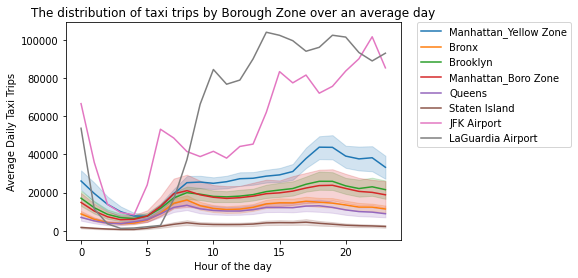

In [18]:
import seaborn as sns
import matplotlib.pylab as plt
ax = sns.lineplot(data=figure_2_data, x = 'Hour', y = 'Count', hue='Borough_Zone')
ax.set(xlabel='Hour of the day', ylabel='Average Daily Taxi Trips')
plt.setp(ax.get_legend().get_texts(), fontsize='6') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='11') 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('The distribution of taxi trips by Borough Zone over an average day')
plt
# This is saved manually via the plots save feature (far left)

In [19]:
# Need to now finish pre processing steps

In [20]:
# We can now join the 2 dataframes
taxi_dataset = all_combinations.join(taxi_data_agg, on = ['hourly_timestamp', 'Borough_Zone'], how = 'left_outer')
# Now replace null values (combinations without counts) with 0
taxi_dataset = taxi_dataset.fillna({'Count': 0})

In [21]:
# add day (mon/tue/...) and date (YYYY-MM-DD) to the dataset
taxi_dataset = taxi_dataset.withColumn("Day", date_format('hourly_timestamp', 'EEEE'))
taxi_dataset = taxi_dataset.withColumn("Date", to_date('hourly_timestamp'))
# select final attributes
taxi_dataset = taxi_dataset.select('Date','hourly_timestamp', 'Day', 'Borough_Zone', 'Count')


In [22]:
# we have now finished the first part of preprocessing, and will save it in curated data 
taxi_dataset.write.parquet('../data/curated/taxi_data.parquet', mode = 'overwrite')